<a href="https://colab.research.google.com/github/haoboooo/Temporal-Generalization-of-Sentiment-Analysis-on-Amazon-Reviews/blob/main/amazon_fashion/fashion_finetune_adapter.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install emot
!pip install -U adapter-transformers
!pip install datasets

     |████████████████████████████████| 61 kB 21 kB/s 
     |████████████████████████████████| 3.9 MB 4.1 MB/s 
     |████████████████████████████████| 596 kB 64.7 MB/s 
     |████████████████████████████████| 6.6 MB 48.7 MB/s 
     |████████████████████████████████| 84 kB 2.6 MB/s 
     |████████████████████████████████| 880 kB 55.6 MB/s 
  Created wheel for sacremoses: filename=sacremoses-0.0.53-py3-none-any.whl size=895260 sha256=e65ba5e96a42c4f886aeba4e009f3443832eaf6809fcca85ec720ce0df269d57
  Stored in directory: /root/.cache/pip/wheels/87/39/dd/a83eeef36d0bf98e7a4d1933a4ad2d660295a40613079bafc9
Successfully built sacremoses
  Attempting uninstall: pyyaml
    Found existing installation: PyYAML 3.13
    Uninstalling PyYAML-3.13:
      Successfully uninstalled PyYAML-3.13
     |████████████████████████████████| 342 kB 4.0 MB/s 
     |████████████████████████████████| 1.1 MB 77.3 MB/s 
     |████████████████████████████████| 140 kB 84.1 MB/s 
     |████████████████████████████████|

In [ ]:
import pandas as pd
import numpy as np
import string
import os

# text preprocessing
import nltk
from nltk import word_tokenize
from nltk.corpus import stopwords
import re
from emot.emo_unicode import EMOTICONS_EMO, UNICODE_EMOJI

# plots and metrics
import matplotlib.pyplot as plt
import seaborn as sns
plt.style.use('ggplot')
from sklearn.metrics import accuracy_score, f1_score

import torch
from transformers import RobertaTokenizer
import datasets
from datasets import Dataset
from transformers import RobertaConfig, RobertaModelWithHeads
from transformers import TrainingArguments, AdapterTrainer, EvalPrediction

In [ ]:
nltk.download("stopwords")
nltk.download('punkt')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


True

## load fashion data

In [ ]:
file1 = "./drive/MyDrive/Colab Notebooks/CL/fashion/02_06.csv"
file2 = "./drive/MyDrive/Colab Notebooks/CL/fashion/07_12.csv"
file3 = "./drive/MyDrive/Colab Notebooks/CL/fashion/13_17.csv"
file4 = "./drive/MyDrive/Colab Notebooks/CL/fashion/18.csv"

In [ ]:
def load_data(file):
  # read csv data and set columns
  df = pd.read_csv(file,usecols=['overall', 'reviewTime','reviewText'])

  # remove the duplicates if any
  df.duplicated('reviewText').sum()
  df.drop_duplicates(subset=['reviewText'],inplace=True)
  
  # remove NaN rows
  df.isnull().sum()
  df.dropna(how='any',axis=0,inplace=True)
  shape = df.shape
  counts = df.overall.value_counts()# labels count

  sns.countplot(df['overall']) # plot bar graph
  fig = plt.gcf() # get current figure
  fig.set_size_inches(5,5) # set the figure size
  plt.title('overall') # add title to the figure

  return df,shape,counts

(530, 3)
 1.0    386
-1.0     98
 0.0     46
Name: overall, dtype: int64


/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


,overall,reviewTime,reviewText
0,1.0,2006,This China Silk Black Balaclava is great for k...
1,1.0,2004,This item is very lightweight (as you'd expect...
2,1.0,2006,This item came in only 2 days and in perfect c...
3,1.0,2006,This ring was well worth the price. It has a l...
4,1.0,2006,"It was exactly as described. Beautiful ring, ..."


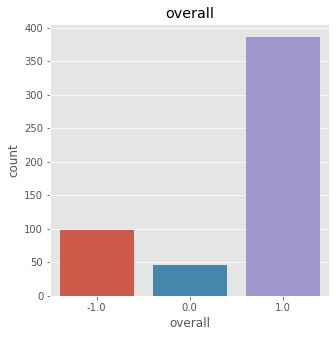

In [ ]:
# load data for 2002 - 2006
df1,shape1,counts1 = load_data(file1)
print(shape1)
print(counts1)
df1.head()

(16800, 3)
 1.0    12574
-1.0     2657
 0.0     1569
Name: overall, dtype: int64


/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


,overall,reviewTime,reviewText
0,-1.0,2012,"I ordered a ladies cigarette case for my wife,..."
1,1.0,2010,Received the case in less than a week...was ve...
2,-1.0,2012,Don't buy this shirt unless you plan to spend ...
3,1.0,2012,"Nice shirt, Well made. good sizing. Nice color..."
4,1.0,2011,If you want a look that takes it back to the O...


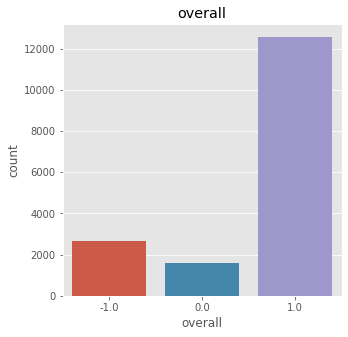

In [ ]:
# load data for 2007 - 2012
df2,shape2,counts2 = load_data(file2)
print(shape2)
print(counts2)
df2.head()

(614812, 3)
 1.0    413534
-1.0    130175
 0.0     71103
Name: overall, dtype: int64


/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


,overall,reviewTime,reviewText
0,1.0,2014,Exactly what I needed.
1,-1.0,2014,"I agree with the other review, the opening is ..."
2,1.0,2014,Love these... I am going to order another pack...
3,-1.0,2014,too tiny an opening
4,0.0,2014,Okay


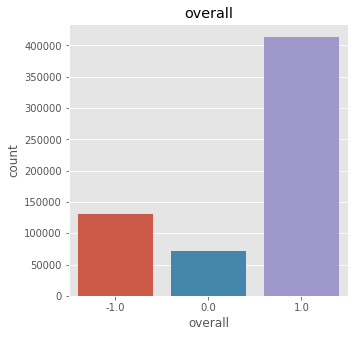

In [ ]:
# load data for 2013 - 2017
df3,shape3,counts3 = load_data(file3)
print(shape3)
print(counts3)
df3.head()

(47246, 3)
 1.0    33622
-1.0     8865
 0.0     4759
Name: overall, dtype: int64


/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


,overall,reviewTime,reviewText
0,1.0,2018,Just what I needed for a party
1,1.0,2018,Son loves it. Decent quality.
2,1.0,2018,My son wanted to dress like August Pullman fro...
3,1.0,2018,awesome.
4,1.0,2018,My daughter loves this item. My high score is ...


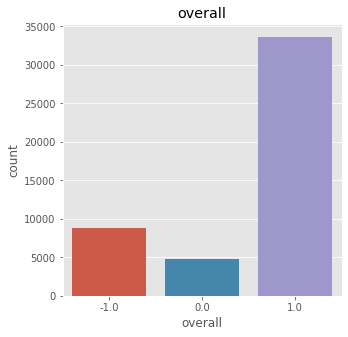

In [ ]:
# load data for 2018
df4,shape4,counts4 = load_data(file4)
print(shape4)
print(counts4)
df4.head()

## Split and Balance train&test

Balance each time period for 
6000 positive，2500 negative，1500 neutral except 2002-2006

80%(8000) training and 20%(2000) testing

In [ ]:
def split_balance(df):
  # get data of each class
  groups = df.groupby(df.overall)
  pos = groups.get_group(1)
  neu = groups.get_group(0)
  neg = groups.get_group(-1)

  # shuffle the dataframe
  pos = pos.sample(frac=1.0)
  neu = neu.sample(frac=1.0)
  neg = neg.sample(frac=1.0)

  # split to get train for each class
  train_posdata = pos.iloc[:4800,:]
  train_neudata = neu.iloc[:1200,:]
  train_negdata = neg.iloc[:2000,:]

  # split to get test for each class
  test_posdata = pos.iloc[4800:6000,:]
  test_neudata = neu.iloc[1200:1500,:]
  test_negdata = neg.iloc[2000:2500,:]

  train = pd.concat([train_posdata, train_neudata, train_negdata],sort=False).sample(frac=1.0)
  test = pd.concat([test_posdata, test_neudata, test_negdata],sort=False).sample(frac=1.0)

  return train,test

In [ ]:
# No data for 2002 - 2006
# df1_train,df1_test = split_balance(df1)

# data for 2007 - 2012
df1_train,df1_test = split_balance(df2)

# data for 2013 - 2017
df2_train,df2_test = split_balance(df3)

# data for 2018
df3_train,df3_test = split_balance(df4)

In [ ]:
df1_train["overall"] = df1_train["overall"].replace(-1,2)
df1_test["overall"] = df1_test["overall"].replace(-1,2)

df2_train["overall"] = df2_train["overall"].replace(-1,2)
df2_test["overall"] = df2_test["overall"].replace(-1,2)

df3_train["overall"] = df3_train["overall"].replace(-1,2)
df3_test["overall"] = df3_test["overall"].replace(-1,2)

In [ ]:
df1_train.head()

,overall,reviewTime,reviewText
6920,1.0,2007,"Okay -- my wife calls it my ""man purse"" -- but..."
12147,1.0,2009,"this buckle came just as expected, very nice, ..."
3333,2.0,2012,"I'm 4'11"" for reference. I started wearing th..."
4692,1.0,2012,My 5 year old daughter is very particular and ...
1233,1.0,2012,This product is as good if not better than the...


## Text Preprocessing

In [ ]:
# get stopwords from txt
def get_stop_words(txt):
    #read the stop words
    with open(txt,'r') as f:
        stopwords_list=f.readlines()
    for i in range (0,len(stopwords_list)):
        stopwords_list[i]=stopwords_list[i].replace('\n','')
    return stopwords_list

In [ ]:
# Defining my NLTK stop words and my user-defined stop words
stop_words = list(stopwords.words('english'))
alphabets = list(string.ascii_lowercase) # 26 letters with lowercase
user_stop_words = get_stop_words("./drive/MyDrive/Colab Notebooks/CL/stopwords.txt")
stop_words = stop_words+alphabets+user_stop_words
emojis = {**UNICODE_EMOJI,**EMOTICONS_EMO} # full list of emojis unicodes

In [ ]:
def processtext(txt):
  # replace all emojis
  for emo in emojis.keys():
    txt = txt.replace(emo,"EMOJI "+emojis[emo])
  
  txt = txt.replace('\r', '').replace('\n', ' ')
  # remove all html tag
  txt = re.sub("(<.*?>)", "", txt)
  # remove all urls
  txt = re.sub('https?:\/\/\S+','',txt)
  # remove @ references  
  txt = re.sub('@[\w_]+','',txt)
  # remove # hashtags
  txt = re.sub('#\S+','',txt)
  # replace digits with no space
  txt = re.sub(r"\d", '',txt)
  # convert tweet to lower case
  txt = txt.lower()
  # remove all multiple white spaces
  txt = re.sub('[\s]+',' ',txt)
  # remove all punctuations and non-ascii
  txt = re.sub('[\.?!,;:\-\[\]\{\}\(\)\'\"/]','',txt)
  txt = txt.replace('$','').replace('&','')
  # remove whitespace
  txt = txt.strip()

  tokens = word_tokenize(txt)
  filtered_words = [w for w in tokens if w not in stop_words]
  # filtered_words = [w for w in filtered_words if w in word_list]
  return " ".join(filtered_words)

In [ ]:
df1_train["cleanText"] = df1_train["reviewText"].apply(processtext)
df1_test["cleanText"] = df1_test["reviewText"].apply(processtext)

df2_train["cleanText"] = df2_train["reviewText"].apply(processtext)
df2_test["cleanText"] = df2_test["reviewText"].apply(processtext)

df3_train["cleanText"] = df3_train["reviewText"].apply(processtext)
df3_test["cleanText"] = df3_test["reviewText"].apply(processtext)

## Tokenization

In [ ]:
tokenizer = RobertaTokenizer.from_pretrained("roberta-base")

def encode_batch(batch):
  """Encodes a batch of input data using the model tokenizer."""
  return tokenizer(batch["text"], max_length=128, truncation=True, padding="max_length")

Downloading:   0%|          | 0.00/878k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/446k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/481 [00:00<?, ?B/s]

In [ ]:
def generate_datasetdict(dataframe1,dataframe2):
  text1 = dataframe1.cleanText.values
  text2 = dataframe2.cleanText.values

  label1 = dataframe1.overall.values.astype(np.int32)
  label2 = dataframe2.overall.values.astype(np.int32)

  train_df = pd.DataFrame({"label" : label1,"text" : text1})
  test_df = pd.DataFrame({"label" : label2,"text" : text2})

  train_dataset = Dataset.from_dict(train_df)
  test_dataset = Dataset.from_dict(test_df)
  my_dataset_dict = datasets.DatasetDict({"train":train_dataset,"test":test_dataset})

  # Encode the input data
  dataset = my_dataset_dict.map(encode_batch, batched=True)
  # The transformers model expects the target class column to be named "labels"
  # dataset.rename_column(original_column_name="label", new_column_name="labels")
  # Transform to pytorch tensors and only output the required columns
  dataset.set_format(type="torch", columns=["input_ids", "attention_mask", "label"])

  return dataset

In [ ]:
df1_dataset = generate_datasetdict(df1_train,df1_test)
df2_dataset = generate_datasetdict(df2_train,df2_test)
df3_dataset = generate_datasetdict(df3_train,df3_test)

  0%|          | 0/8 [00:00<?, ?ba/s]

  0%|          | 0/2 [00:00<?, ?ba/s]

  0%|          | 0/8 [00:00<?, ?ba/s]

  0%|          | 0/2 [00:00<?, ?ba/s]

  0%|          | 0/8 [00:00<?, ?ba/s]

  0%|          | 0/2 [00:00<?, ?ba/s]

## Train Adapters

### adapter learning from 2007-2012

In [ ]:
config = RobertaConfig.from_pretrained(
    "roberta-base",
    num_labels=3,
)
model = RobertaModelWithHeads.from_pretrained(
    "roberta-base",
    config=config,
)

/usr/local/lib/python3.7/dist-packages/transformers/adapters/models/roberta.py:255: FutureWarning: This class has been renamed to `RobertaAdapterModel` in v3. Please use the new class instead as this class might be removed in a future version.
  FutureWarning,


Downloading:   0%|          | 0.00/478M [00:00<?, ?B/s]

/usr/local/lib/python3.7/dist-packages/transformers/adapters/models/roberta.py:233: FutureWarning: This class has been renamed to `RobertaAdapterModel` in v3. Please use the new class instead as this class might be removed in a future version.
  FutureWarning,
Some weights of the model checkpoint at roberta-base were not used when initializing RobertaModelWithHeads: ['lm_head.dense.weight', 'lm_head.dense.bias', 'lm_head.layer_norm.weight', 'lm_head.decoder.weight', 'lm_head.layer_norm.bias', 'lm_head.bias']
- This IS expected if you are initializing RobertaModelWithHeads from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaModelWithHeads from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weig

In [ ]:
# Add a new adapter
model.add_adapter("amazon_review")
# Add a matching classification head
model.add_classification_head(
    "amazon_review",
    num_labels=3,
    id2label={ 0: "neutral", 1: "positive", 2: "negative"}
  )
# Activate the adapter
model.train_adapter("amazon_review")

In [ ]:
training_args = TrainingArguments(
    learning_rate=1e-4,
    num_train_epochs=6,
    per_device_train_batch_size=32,
    per_device_eval_batch_size=32,
    logging_steps=200,
    output_dir="./training_output",
    overwrite_output_dir=True,
    # The next line is important to ensure the dataset labels are properly passed to the model
    remove_unused_columns=False,
)

def compute_accuracy(p: EvalPrediction):
  preds = np.argmax(p.predictions, axis=1)
  return {"acc": (preds == p.label_ids).mean()}

trainer = AdapterTrainer(
    model=model,
    args=training_args,
    train_dataset=df1_dataset["train"],
    eval_dataset=df1_dataset["test"],
    compute_metrics=compute_accuracy,
)

In [ ]:
trainer.train()

/usr/local/lib/python3.7/dist-packages/transformers/optimization.py:309: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  FutureWarning,
***** Running training *****
  Num examples = 8000
  Num Epochs = 6
  Instantaneous batch size per device = 32
  Total train batch size (w. parallel, distributed & accumulation) = 32
  Gradient Accumulation steps = 1
  Total optimization steps = 1500


Step,Training Loss
200,0.787400
400,0.598800
600,0.562900
800,0.531500
1000,0.520000
1200,0.499800
1400,0.490300


Saving model checkpoint to ./training_output/checkpoint-500
Configuration saved in ./training_output/checkpoint-500/amazon_review/adapter_config.json
Module weights saved in ./training_output/checkpoint-500/amazon_review/pytorch_adapter.bin
Configuration saved in ./training_output/checkpoint-500/amazon_review/head_config.json
Module weights saved in ./training_output/checkpoint-500/amazon_review/pytorch_model_head.bin
Configuration saved in ./training_output/checkpoint-500/amazon_review/head_config.json
Module weights saved in ./training_output/checkpoint-500/amazon_review/pytorch_model_head.bin
Saving model checkpoint to ./training_output/checkpoint-1000
Configuration saved in ./training_output/checkpoint-1000/amazon_review/adapter_config.json
Module weights saved in ./training_output/checkpoint-1000/amazon_review/pytorch_adapter.bin
Configuration saved in ./training_output/checkpoint-1000/amazon_review/head_config.json
Module weights saved in ./training_output/checkpoint-1000/amazon_

TrainOutput(global_step=1500, training_loss=0.5646869837443034, metrics={'train_runtime': 398.6006, 'train_samples_per_second': 120.421, 'train_steps_per_second': 3.763, 'total_flos': 3212108476416000.0, 'train_loss': 0.5646869837443034, 'epoch': 6.0})

In [ ]:
trainer.evaluate()

***** Running Evaluation *****
  Num examples = 2000
  Batch size = 32


{'epoch': 6.0,
 'eval_acc': 0.786,
 'eval_loss': 0.5264761447906494,
 'eval_runtime': 8.3136,
 'eval_samples_per_second': 240.568,
 'eval_steps_per_second': 7.578}

In [ ]:
trainer.predict(df2_dataset["test"])

***** Running Prediction *****
  Num examples = 2000
  Batch size = 32


PredictionOutput(predictions=array([[ 0.3201542 , -1.0890814 ,  1.3581989 ],
       [ 0.3950204 , -2.2140656 ,  2.2126906 ],
       [-0.74789095,  3.332375  , -1.9038587 ],
       ...,
       [-0.47881234,  2.7613606 , -1.828698  ],
       [-0.92786515,  3.88345   , -2.5087726 ],
       [ 0.35697755, -2.805666  ,  2.7195132 ]], dtype=float32), label_ids=array([2, 2, 1, ..., 1, 1, 2]), metrics={'test_loss': 0.5469914674758911, 'test_acc': 0.7665, 'test_runtime': 8.302, 'test_samples_per_second': 240.907, 'test_steps_per_second': 7.589})

In [ ]:
trainer.predict(df3_dataset["test"])

***** Running Prediction *****
  Num examples = 2000
  Batch size = 32


PredictionOutput(predictions=array([[-1.0811493 ,  3.574014  , -2.0937603 ],
       [ 0.48474246, -2.7331724 ,  2.721499  ],
       [ 0.11139767,  2.4810033 , -1.9287305 ],
       ...,
       [-0.83991563,  2.0229855 , -0.8767447 ],
       [-0.37146923, -2.238679  ,  2.7684214 ],
       [ 0.3937164 ,  1.5299673 , -1.2078819 ]], dtype=float32), label_ids=array([1, 2, 1, ..., 1, 2, 1]), metrics={'test_loss': 0.5818402171134949, 'test_acc': 0.7675, 'test_runtime': 8.2873, 'test_samples_per_second': 241.333, 'test_steps_per_second': 7.602})

### adapter finetuning from 2013-2017

In [ ]:
trainer2 = AdapterTrainer(
    model=model,
    args=training_args,
    train_dataset=df2_dataset["train"],
    eval_dataset=df2_dataset["test"],
    compute_metrics=compute_accuracy,
)

In [ ]:
trainer2.train()

/usr/local/lib/python3.7/dist-packages/transformers/optimization.py:309: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  FutureWarning,
***** Running training *****
  Num examples = 8000
  Num Epochs = 6
  Instantaneous batch size per device = 32
  Total train batch size (w. parallel, distributed & accumulation) = 32
  Gradient Accumulation steps = 1
  Total optimization steps = 1500


Step,Training Loss
200,0.582200
400,0.543600
600,0.527300
800,0.516600
1000,0.496900
1200,0.488900
1400,0.478600


Saving model checkpoint to ./training_output/checkpoint-500
Configuration saved in ./training_output/checkpoint-500/amazon_review/adapter_config.json
Module weights saved in ./training_output/checkpoint-500/amazon_review/pytorch_adapter.bin
Configuration saved in ./training_output/checkpoint-500/amazon_review/head_config.json
Module weights saved in ./training_output/checkpoint-500/amazon_review/pytorch_model_head.bin
Configuration saved in ./training_output/checkpoint-500/amazon_review/head_config.json
Module weights saved in ./training_output/checkpoint-500/amazon_review/pytorch_model_head.bin
Saving model checkpoint to ./training_output/checkpoint-1000
Configuration saved in ./training_output/checkpoint-1000/amazon_review/adapter_config.json
Module weights saved in ./training_output/checkpoint-1000/amazon_review/pytorch_adapter.bin
Configuration saved in ./training_output/checkpoint-1000/amazon_review/head_config.json
Module weights saved in ./training_output/checkpoint-1000/amazon_

TrainOutput(global_step=1500, training_loss=0.5161360015869141, metrics={'train_runtime': 397.6111, 'train_samples_per_second': 120.721, 'train_steps_per_second': 3.773, 'total_flos': 3212108476416000.0, 'train_loss': 0.5161360015869141, 'epoch': 6.0})

In [ ]:
trainer2.evaluate()

***** Running Evaluation *****
  Num examples = 2000
  Batch size = 32


{'epoch': 6.0,
 'eval_acc': 0.792,
 'eval_loss': 0.515959620475769,
 'eval_runtime': 8.2943,
 'eval_samples_per_second': 241.13,
 'eval_steps_per_second': 7.596}

In [ ]:
trainer2.predict(df1_dataset["test"])

***** Running Prediction *****
  Num examples = 2000
  Batch size = 32


PredictionOutput(predictions=array([[-1.5544727 ,  4.755107  , -2.718006  ],
       [ 0.13028583, -3.0533872 ,  3.1077154 ],
       [ 0.80782306,  1.0684761 , -1.437184  ],
       ...,
       [-1.8237767 ,  5.45442   , -3.1662114 ],
       [-0.3750565 ,  3.3606894 , -2.5762837 ],
       [-1.1841792 ,  4.476311  , -2.6976857 ]], dtype=float32), label_ids=array([1, 0, 0, ..., 1, 0, 1]), metrics={'test_loss': 0.5229564309120178, 'test_acc': 0.795, 'test_runtime': 8.2981, 'test_samples_per_second': 241.018, 'test_steps_per_second': 7.592})

In [ ]:
trainer2.predict(df3_dataset["test"])

***** Running Prediction *****
  Num examples = 2000
  Batch size = 32


PredictionOutput(predictions=array([[-1.2071424 ,  3.553944  , -2.0609567 ],
       [ 0.5767564 , -3.4990878 ,  3.3798034 ],
       [-0.11756381,  2.6891267 , -1.9282689 ],
       ...,
       [-0.6786194 ,  1.7655429 , -0.80197257],
       [-0.35943374, -2.28325   ,  2.7797554 ],
       [ 0.15861449,  2.1857932 , -1.6909361 ]], dtype=float32), label_ids=array([1, 2, 1, ..., 1, 2, 1]), metrics={'test_loss': 0.5586031079292297, 'test_acc': 0.7675, 'test_runtime': 8.2942, 'test_samples_per_second': 241.132, 'test_steps_per_second': 7.596})

### adapter finetuning from 2018

In [ ]:
trainer3 = AdapterTrainer(
    model=model,
    args=training_args,
    train_dataset=df3_dataset["train"],
    eval_dataset=df3_dataset["test"],
    compute_metrics=compute_accuracy,
)

In [ ]:
trainer3.train()

/usr/local/lib/python3.7/dist-packages/transformers/optimization.py:309: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  FutureWarning,
***** Running training *****
  Num examples = 8000
  Num Epochs = 6
  Instantaneous batch size per device = 32
  Total train batch size (w. parallel, distributed & accumulation) = 32
  Gradient Accumulation steps = 1
  Total optimization steps = 1500


Step,Training Loss
200,0.542500
400,0.514900
600,0.515300
800,0.496200
1000,0.475400
1200,0.468800
1400,0.449600


Saving model checkpoint to ./training_output/checkpoint-500
Configuration saved in ./training_output/checkpoint-500/amazon_review/adapter_config.json
Module weights saved in ./training_output/checkpoint-500/amazon_review/pytorch_adapter.bin
Configuration saved in ./training_output/checkpoint-500/amazon_review/head_config.json
Module weights saved in ./training_output/checkpoint-500/amazon_review/pytorch_model_head.bin
Configuration saved in ./training_output/checkpoint-500/amazon_review/head_config.json
Module weights saved in ./training_output/checkpoint-500/amazon_review/pytorch_model_head.bin
Saving model checkpoint to ./training_output/checkpoint-1000
Configuration saved in ./training_output/checkpoint-1000/amazon_review/adapter_config.json
Module weights saved in ./training_output/checkpoint-1000/amazon_review/pytorch_adapter.bin
Configuration saved in ./training_output/checkpoint-1000/amazon_review/head_config.json
Module weights saved in ./training_output/checkpoint-1000/amazon_

TrainOutput(global_step=1500, training_loss=0.4922934366861979, metrics={'train_runtime': 397.5022, 'train_samples_per_second': 120.754, 'train_steps_per_second': 3.774, 'total_flos': 3212108476416000.0, 'train_loss': 0.4922934366861979, 'epoch': 6.0})

In [ ]:
trainer3.evaluate()

***** Running Evaluation *****
  Num examples = 2000
  Batch size = 32


{'epoch': 6.0,
 'eval_acc': 0.771,
 'eval_loss': 0.5445203185081482,
 'eval_runtime': 8.3122,
 'eval_samples_per_second': 240.611,
 'eval_steps_per_second': 7.579}

In [ ]:
trainer3.predict(df1_dataset["test"])

***** Running Prediction *****
  Num examples = 2000
  Batch size = 32


PredictionOutput(predictions=array([[-1.9440073 ,  5.2114687 , -2.7787685 ],
       [ 0.1181143 , -2.916714  ,  3.1580055 ],
       [ 0.7623597 ,  1.10928   , -1.3646424 ],
       ...,
       [-2.000898  ,  5.2443333 , -2.7681475 ],
       [-0.38437423,  2.997938  , -2.1640692 ],
       [-1.2137197 ,  4.094017  , -2.2343392 ]], dtype=float32), label_ids=array([1, 0, 0, ..., 1, 0, 1]), metrics={'test_loss': 0.5179065465927124, 'test_acc': 0.808, 'test_runtime': 8.3247, 'test_samples_per_second': 240.249, 'test_steps_per_second': 7.568})

In [ ]:
trainer3.predict(df2_dataset["test"])

***** Running Prediction *****
  Num examples = 2000
  Batch size = 32


PredictionOutput(predictions=array([[ 0.61228764, -2.1647766 ,  2.1546779 ],
       [-0.04979021, -2.811723  ,  3.3888257 ],
       [-1.0552485 ,  3.8704002 , -2.1160505 ],
       ...,
       [-1.354702  ,  4.6042933 , -2.6705751 ],
       [-1.405353  ,  4.426944  , -2.4566426 ],
       [ 0.28202823, -2.693123  ,  2.8065138 ]], dtype=float32), label_ids=array([2, 2, 1, ..., 1, 1, 2]), metrics={'test_loss': 0.5049028992652893, 'test_acc': 0.791, 'test_runtime': 8.2995, 'test_samples_per_second': 240.979, 'test_steps_per_second': 7.591})